In [6]:
%%capture
# required packages
!pip install neuralforecast autogluon datasetsforecast

# Customizing the Time Series

In [7]:
import pandas as pd
import numpy as np
from datasetsforecast.m4 import M4
import matplotlib.pyplot as plt
import tensorflow as tf

In [8]:
# Load Data
df, *_ = M4.load('./data', group='Weekly')
# Randomly select three items
df = df[df['unique_id'].isin(['W96', 'W100', 'W99'])]
# Define the start date (for example, "1970-01-04")
start_date = pd.to_datetime("1970-01-04")
# Convert 'ds' to actual week dates
df['ds'] = start_date + pd.to_timedelta(df['ds'] - 1, unit='W')
# Display the DataFrame
df.head()

,unique_id,ds,y
3139,W100,1970-01-04,305.318
3140,W100,1970-01-11,293.278
3141,W100,1970-01-18,291.098
3142,W100,1970-01-25,288.308
3143,W100,1970-02-01,297.428


In [9]:
df.groupby('unique_id').count()

,ds,y
unique_id,,
W100,2296,2296
W96,2296,2296
W99,2296,2296


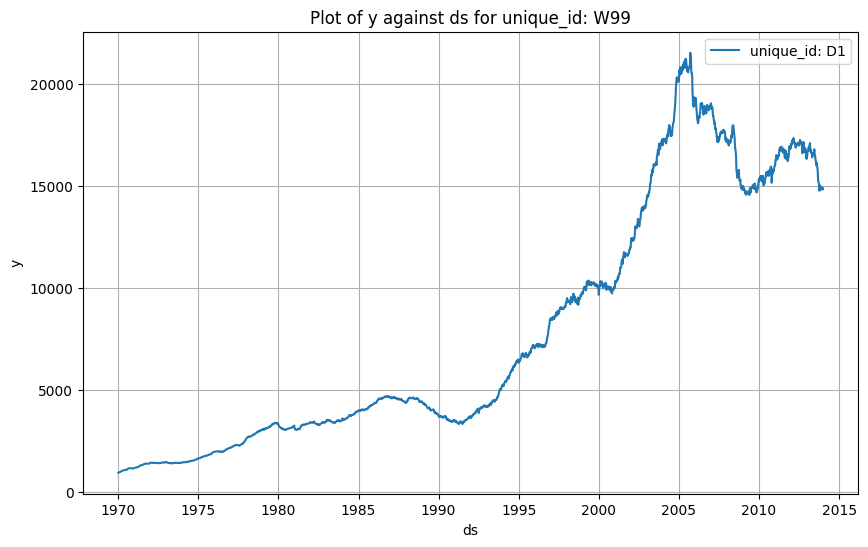

In [10]:
subset = df[df['unique_id'] == 'W99']
plt.figure(figsize=(10, 6))
plt.plot(subset['ds'], subset['y'], label=f'unique_id: D1')
plt.title(f'Plot of y against ds for unique_id: W99')
plt.xlabel('ds')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
print(df.unique_id.nunique())
print(df.ds.nunique())

3
2296


#  Build a Simple One From Scratch

In [12]:
input_shape = (104, 1)
quantiles = [0.1, 0.5, 0.9]
output_steps = 12
cut_off_date = '2013-10-13'
tf.random.set_seed(20240710)

In [13]:
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, concatenate, Layer

In [14]:
# Preprocess The Data
def preprocess_data(df, window_size = 104, forecast_horizon = 12):
    # Ensure the dataframe is sorted by SKU and date

    df = df.sort_values(by=['unique_id', 'ds'])
    # List to hold processed data for each SKU
    X, y, unique_id, ds = [], [], [], []
    # Normalizer
    scaler = StandardScaler()
    # Iterate through each SKU
    for key, group in df.groupby('unique_id'):
        demand = group['y'].values.reshape(-1, 1)
        scaled_demand = scaler.fit_transform(demand)
        dates = group['ds'].values
        # Create sequences (sliding window approach)
        for i in range(len(scaled_demand) - window_size - forecast_horizon + 1):
            X.append(scaled_demand[i:i+window_size])
            y.append(scaled_demand[i+window_size:i+window_size+forecast_horizon].flatten())
            unique_id.append(key)
            ds.append(dates[i+window_size:i+window_size+forecast_horizon])
    X = np.array(X)
    y = np.array(y)
    return X, y, unique_id, ds, scaler

In [15]:
# Split Data
def split_data(X, y, unique_id, ds, cut_off_date):
    cut_off_date = pd.to_datetime(cut_off_date)
    val_start_date = cut_off_date - pd.Timedelta(weeks=12)
    train_idx = [i for i, date in enumerate(ds) if date[0] < val_start_date]
    val_idx = [i for i, date in enumerate(ds) if val_start_date <= date[0] < cut_off_date]
    test_idx = [i for i, date in enumerate(ds) if date[0] >= cut_off_date]

    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]
    X_test, y_test = X[test_idx], y[test_idx]

    train_unique_id = [unique_id[i] for i in train_idx]
    train_ds = [ds[i] for i in train_idx]
    val_unique_id = [unique_id[i] for i in val_idx]
    val_ds = [ds[i] for i in val_idx]
    test_unique_id = [unique_id[i] for i in test_idx]
    test_ds = [ds[i] for i in test_idx]

    return X_train, y_train, X_val, y_val, X_test, y_test, train_unique_id, train_ds, val_unique_id, val_ds, test_unique_id, test_ds

In [16]:
# Attention Layer
class Attention(Layer):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)
    def call(self, query, values):
        hidden_with_time_axis = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

# Quantile Loss Function
def quantile_loss(q, y_true, y_pred):
    e = y_true - y_pred
    return tf.reduce_mean(tf.maximum(q*e, (q-1)*e))

def combined_quantile_loss(quantiles, y_true, y_pred, output_steps):
    losses = [quantile_loss(q, y_true, y_pred[:, i*output_steps:(i+1)*output_steps]) for i, q in enumerate(quantiles)]
    return tf.reduce_mean(losses)

# Model architecture
def create_model(input_shape, quantiles, output_steps):
    inputs = Input(shape=input_shape)
    lstm1 = LSTM(256, return_sequences=True)(inputs)
    lstm_out, state_h, state_c = LSTM(256, return_sequences=True, return_state=True)(lstm1)
    context_vector, attention_weights = Attention(256)(state_h, lstm_out)
    global_context = Dense(100, activation = 'relu')(context_vector)
    forecasts = []
    for q in quantiles:
        local_context = concatenate([global_context, context_vector])
        forecast = Dense(output_steps, activation = 'linear')(local_context)
        forecasts.append(forecast)
    outputs = concatenate(forecasts, axis=1)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss=lambda y, f: combined_quantile_loss(quantiles, y, f, output_steps))
    return model

In [17]:
# Calculate the SMAPE
def smape(actual, predicted):
  """
  Calculates the Symmetric Mean Absolute Percentage Error (SMAPE) between two arrays.

  Args:
      actual: The array of actual values.
      predicted: The array of predicted values.

  Returns:
      The SMAPE value.
  """

  numerator = np.abs(actual - predicted)
  denominator = (np.abs(actual) + np.abs(predicted)) / 2

  # Handle cases where denominator is zero
  denominator[denominator == 0] = 1

  return np.mean(numerator / denominator) * 100

In [18]:
def calculate_coverage(result_df):
    coverage_list = []
    for unique_id in result_df.unique_id.unique():
        df_temp = result_df[result_df.unique_id == unique_id]
        coverage = np.mean((df_temp['y'] >= df_temp['P10']) & (df_temp['y'] <= df_temp['P90'])) * 100
        coverage_list.append({'unique_id': unique_id, 'coverage': coverage}) # Append to list
    return pd.DataFrame(coverage_list) # Create DataFrame outside the loop

In [25]:
result_df = pd.DataFrame({})

for i in ['W96', 'W100', 'W99']:

    # Subset data
    df_temp = df[df.unique_id == i]
    # Process the data
    X, y, unique_id, ds, scaler = preprocess_data(df_temp)
    # Split data
    X_train, y_train, X_val, y_val, X_test, y_test, \
    train_unique_id, train_ds, val_unique_id, val_ds, test_unique_id, test_ds = split_data(X, y, unique_id, ds, cut_off_date)
    # Modeling
    model = create_model(input_shape, quantiles, output_steps)
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=128)

    # Evaluate the model
    predictions = model.predict(X_test)

    # Initialize result_df
    result_df_temp = pd.DataFrame({
        'unique_id': np.repeat(test_unique_id, output_steps),
        'ds': np.concatenate(test_ds)
    })
    # Add prediction columns for each quantile
    for i, q in enumerate(quantiles):
        quantile_col = f'P{int(q * 100)}'
        result_df_temp[quantile_col] = predictions[:, i * output_steps:(i + 1) * output_steps].flatten()
    # Clip negative values in the prediction columns
    prediction_columns = [f'P{int(q * 100)}' for q in quantiles]
    result_df_temp[prediction_columns] = result_df_temp[prediction_columns].clip(lower=0)
    result_df_temp[['P10', 'P50', 'P90']] = scaler.inverse_transform(result_df_temp[['P10', 'P50', 'P90']])
    # result_df_temp['Baseline'] = np.median(result_df_temp[['P10', 'P90']], axis=1)
    result_df = pd.concat([result_df, result_df_temp])

Epoch 1/100
17/17 [==============================] - 7s 70ms/step - loss: 0.1351 - val_loss: 0.0852
Epoch 2/100
17/17 [==============================] - 0s 16ms/step - loss: 0.0220 - val_loss: 0.0452
Epoch 3/100
17/17 [==============================] - 0s 16ms/step - loss: 0.0136 - val_loss: 0.0261
Epoch 4/100
17/17 [==============================] - 0s 16ms/step - loss: 0.0096 - val_loss: 0.0204
Epoch 5/100
17/17 [==============================] - 0s 16ms/step - loss: 0.0102 - val_loss: 0.0396
Epoch 6/100
17/17 [==============================] - 0s 16ms/step - loss: 0.0099 - val_loss: 0.0354
Epoch 7/100
17/17 [==============================] - 0s 16ms/step - loss: 0.0082 - val_loss: 0.0283
Epoch 8/100
17/17 [==============================] - 0s 16ms/step - loss: 0.0087 - val_loss: 0.0141
Epoch 9/100
17/17 [==============================] - 0s 16ms/step - loss: 0.0097 - val_loss: 0.0203
Epoch 10/100
17/17 [==============================] - 0s 23ms/step - loss: 0.0086 - val_loss: 0.0163

1/1 [==============================] - 1s 770ms/step
Epoch 1/100
17/17 [==============================] - 6s 71ms/step - loss: 0.1498 - val_loss: 0.0633
Epoch 2/100
17/17 [==============================] - 0s 16ms/step - loss: 0.0293 - val_loss: 0.0273
Epoch 3/100
17/17 [==============================] - 0s 16ms/step - loss: 0.0184 - val_loss: 0.0262
Epoch 4/100
17/17 [==============================] - 0s 16ms/step - loss: 0.0155 - val_loss: 0.0180
Epoch 5/100
17/17 [==============================] - 0s 16ms/step - loss: 0.0137 - val_loss: 0.0168
Epoch 6/100
17/17 [==============================] - 0s 16ms/step - loss: 0.0145 - val_loss: 0.0210
Epoch 7/100
17/17 [==============================] - 0s 16ms/step - loss: 0.0140 - val_loss: 0.0186
Epoch 8/100
17/17 [==============================] - 0s 16ms/step - loss: 0.0132 - val_loss: 0.0147
Epoch 9/100
17/17 [==============================] - 0s 16ms/step - loss: 0.0138 - val_loss: 0.0147
Epoch 10/100
17/17 [===========================

1/1 [==============================] - 1s 870ms/step
Epoch 1/100
17/17 [==============================] - 6s 71ms/step - loss: 0.1460 - val_loss: 0.1248
Epoch 2/100
17/17 [==============================] - 0s 17ms/step - loss: 0.0410 - val_loss: 0.0518
Epoch 3/100
17/17 [==============================] - 0s 18ms/step - loss: 0.0327 - val_loss: 0.0786
Epoch 4/100
17/17 [==============================] - 0s 18ms/step - loss: 0.0287 - val_loss: 0.0854
Epoch 5/100
17/17 [==============================] - 0s 17ms/step - loss: 0.0279 - val_loss: 0.0897
Epoch 6/100
17/17 [==============================] - 0s 17ms/step - loss: 0.0269 - val_loss: 0.0610
Epoch 7/100
17/17 [==============================] - 0s 17ms/step - loss: 0.0260 - val_loss: 0.0865
Epoch 8/100
17/17 [==============================] - 0s 18ms/step - loss: 0.0246 - val_loss: 0.0897
Epoch 9/100
17/17 [==============================] - 0s 17ms/step - loss: 0.0241 - val_loss: 0.0782
Epoch 10/100
17/17 [===========================

In [26]:
result_df = pd.merge(df, result_df, on=['unique_id', 'ds'], how='inner')
result_df.head()

,unique_id,ds,y,P10,P50,P90
0,W100,2013-10-13,11875.50,11019.973633,11397.725586,11741.004883
1,W100,2013-10-20,11517.02,11052.625977,11428.166016,11811.295898
2,W100,2013-10-27,11305.80,10866.204102,11270.621094,11654.429688
3,W100,2013-11-03,11423.14,10963.504883,11307.051758,11712.882812
4,W100,2013-11-10,11647.50,11185.145508,11272.565430,11699.647461


W100


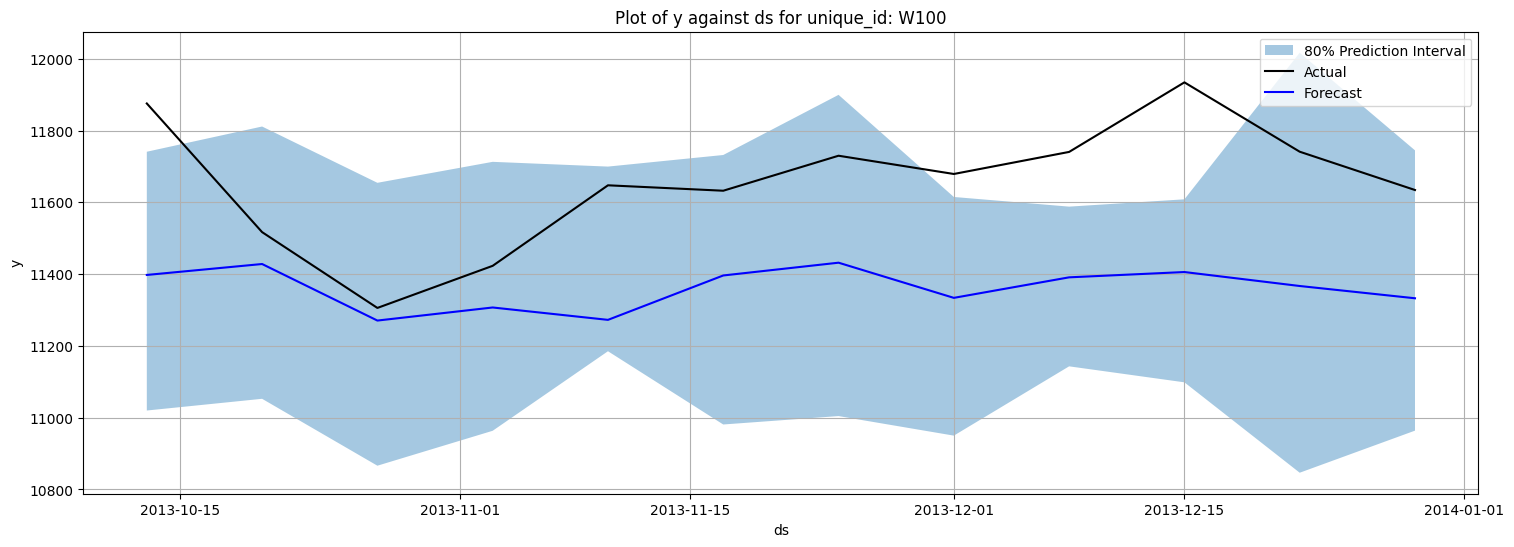

W96


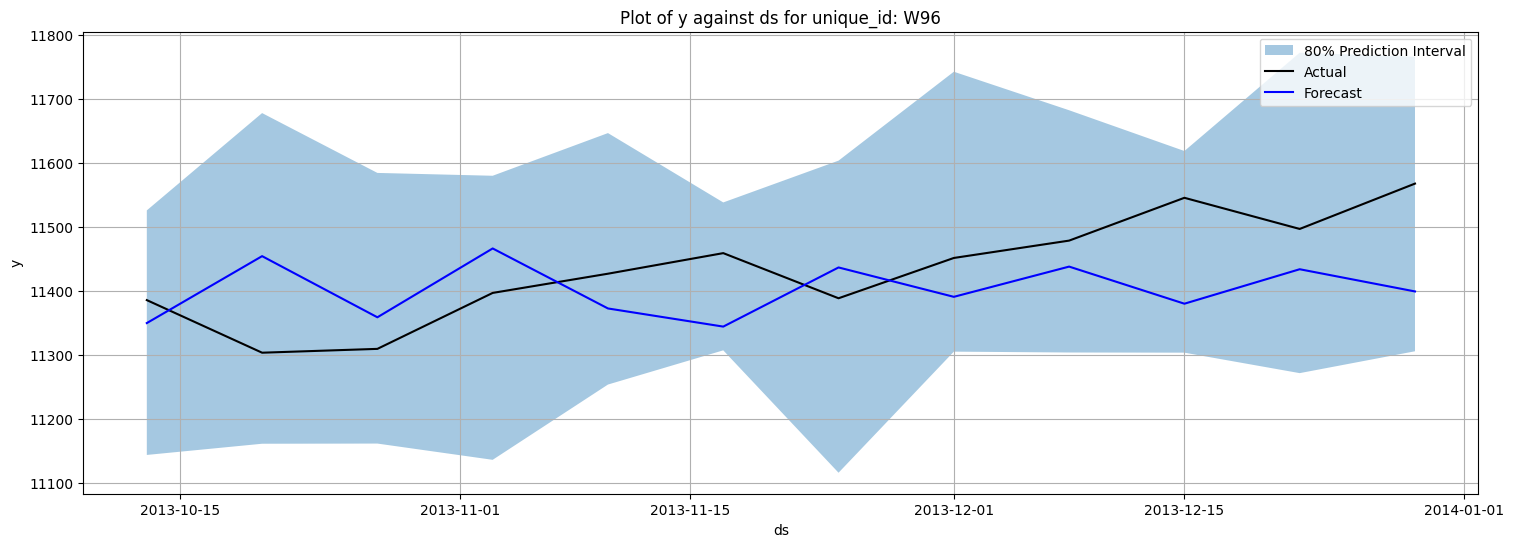

W99


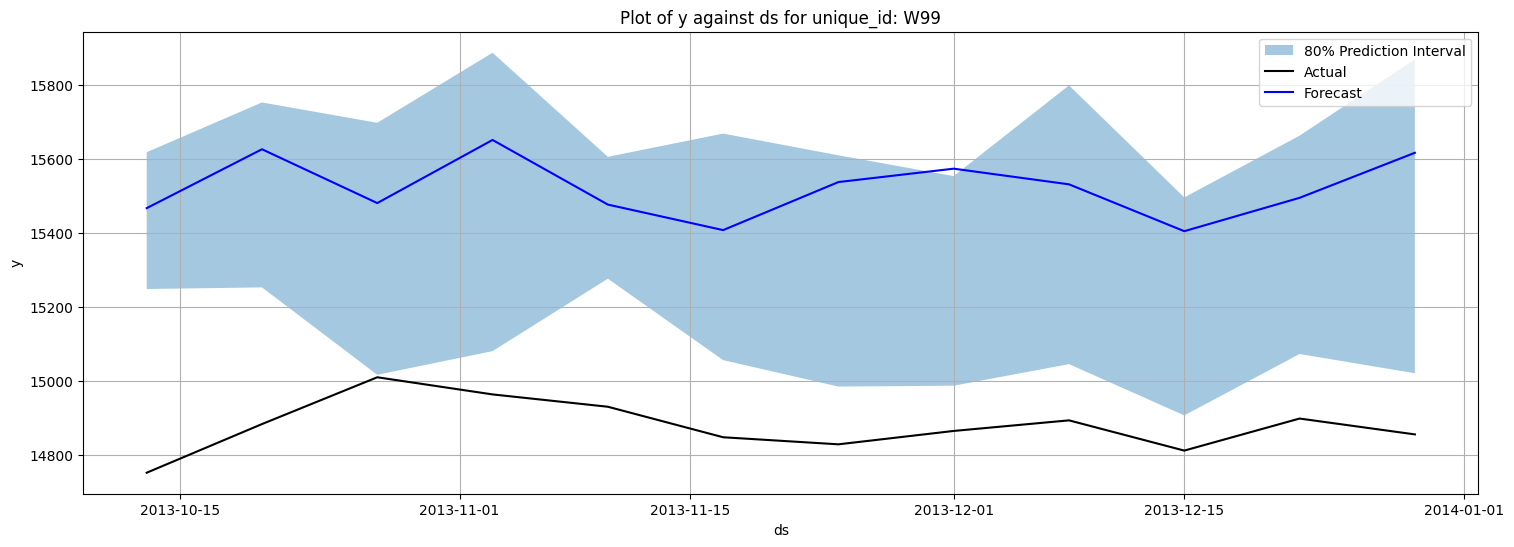

In [27]:
for sku_num in result_df.unique_id.unique():

  print(sku_num)
  plt.figure(figsize=(18, 6))
  plt.fill_between(
      x=result_df[result_df.unique_id == sku_num]['ds'],
      y1=result_df[result_df.unique_id == sku_num]['P10'],
      y2=result_df[result_df.unique_id == sku_num]['P90'],
      alpha=0.4,
      label='80% Prediction Interval'
  )
  plt.plot(result_df[result_df.unique_id == sku_num]['ds'], result_df[result_df.unique_id == sku_num]['y'], c='black', label='Actual')
  plt.plot(result_df[result_df.unique_id == sku_num]['ds'], result_df[result_df.unique_id == sku_num]['P50'], c='blue', label='Forecast')
  plt.title(f'Plot of y against ds for unique_id: {sku_num}')
  plt.xlabel('ds')
  plt.ylabel('y')
  plt.legend()
  plt.grid()
  plt.show()

In [28]:
# Calculate SMAPE for each unique_id
for unique_id in result_df.unique_id.unique():
  actual_values = result_df[result_df.unique_id == unique_id]['y']
  predicted_values = result_df[result_df.unique_id == unique_id]['P50']
  smape_value = smape(actual_values, predicted_values)
  print(f"SMAPE for unique_id {unique_id}: {smape_value:.2f}%")


SMAPE for unique_id W100: 2.54%
SMAPE for unique_id W96: 0.75%
SMAPE for unique_id W99: 4.24%


In [29]:
# Calculate the percentage of time whether the true demand fall between the interval for each unique_id
coverage_df = calculate_coverage(result_df)
print(coverage_df.head())


  unique_id    coverage
0      W100   66.666667
1       W96  100.000000
2       W99    0.000000


# Neural Forecast

In [30]:
from neuralforecast.core import NeuralForecast
from neuralforecast.models import PatchTST
from neuralforecast.losses.pytorch import HuberMQLoss, MQLoss

In [31]:
PARAMS = {'input_size': 104,
          'h': output_steps,
          'max_steps': 6000,
          'encoder_layers': 4,
          'start_padding_enabled': False,
          'learning_rate': 1e-4,
          'patch_len': 52,  # Length of each patch
          'hidden_size': 256,  # Size of the hidden layers
          'n_heads': 4,  # Number of attention heads
          'res_attention': True,
          'dropout': 0.1,  # Dropout rate
          'activation': 'gelu',  # Activation function
          'dropout': 0.1,
          'attn_dropout': 0.1,
          'fc_dropout': 0.1,
          'random_seed': 20240710,
          'loss': HuberMQLoss(quantiles=[0.1, 0.5, 0.9]),
          'scaler_type': 'standard',
          'early_stop_patience_steps': 10}

In [32]:
# Get Training Data
train_df = df[df.ds<cut_off_date]

# Fit and predict with PatchTST
models = [PatchTST(**PARAMS)]
nf = NeuralForecast(models=models, freq='W')
nf.fit(df=train_df, val_size=12)
Y_hat_df = nf.predict().reset_index()

INFO:lightning_fabric.utilities.seed:Seed set to 20240710


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [33]:
result_df = pd.merge(df, Y_hat_df, on=['unique_id', 'ds'], how='inner').rename(columns={'PatchTST-median': 'PatchTST', 'PatchTST-lo-80.0': 'P10', 'PatchTST-hi-80.0': 'P90'})
result_df.head()

,unique_id,ds,y,P10,PatchTST,P90
0,W100,2013-10-13,11875.50,11497.126953,11543.609375,11661.016602
1,W100,2013-10-20,11517.02,11342.767578,11435.113281,11567.414062
2,W100,2013-10-27,11305.80,11335.973633,11444.652344,11552.118164
3,W100,2013-11-03,11423.14,11298.346680,11399.447266,11512.440430
4,W100,2013-11-10,11647.50,11447.240234,11598.806641,11711.054688


W100


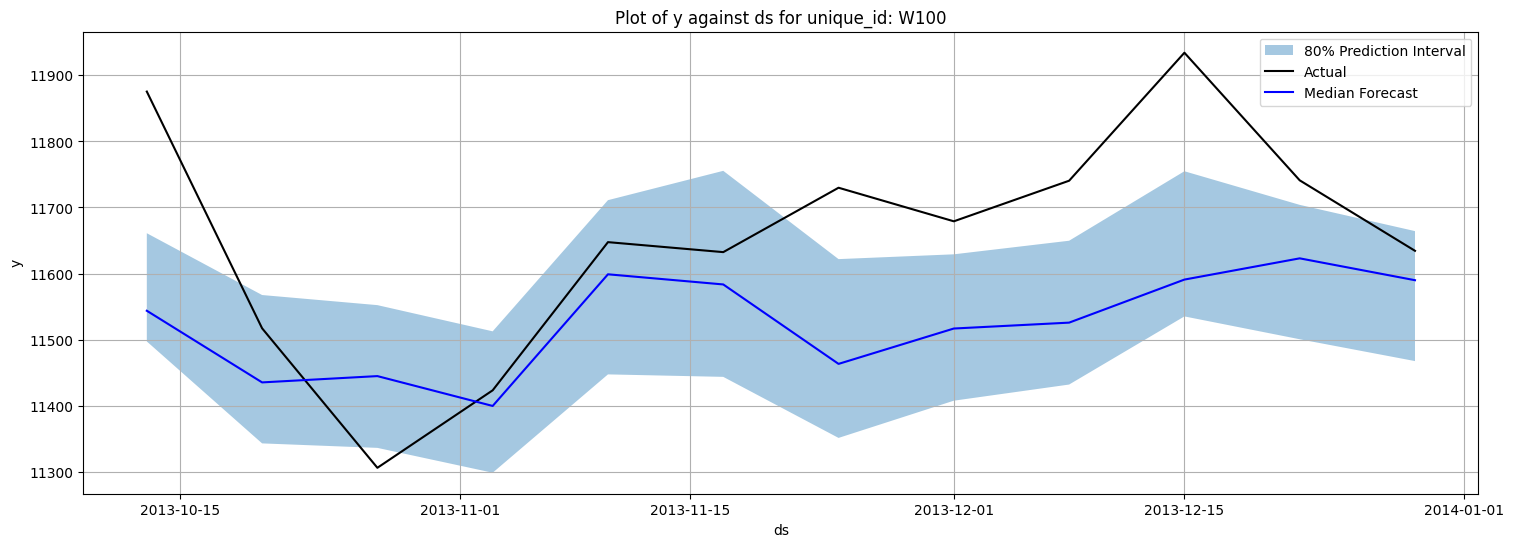

W96


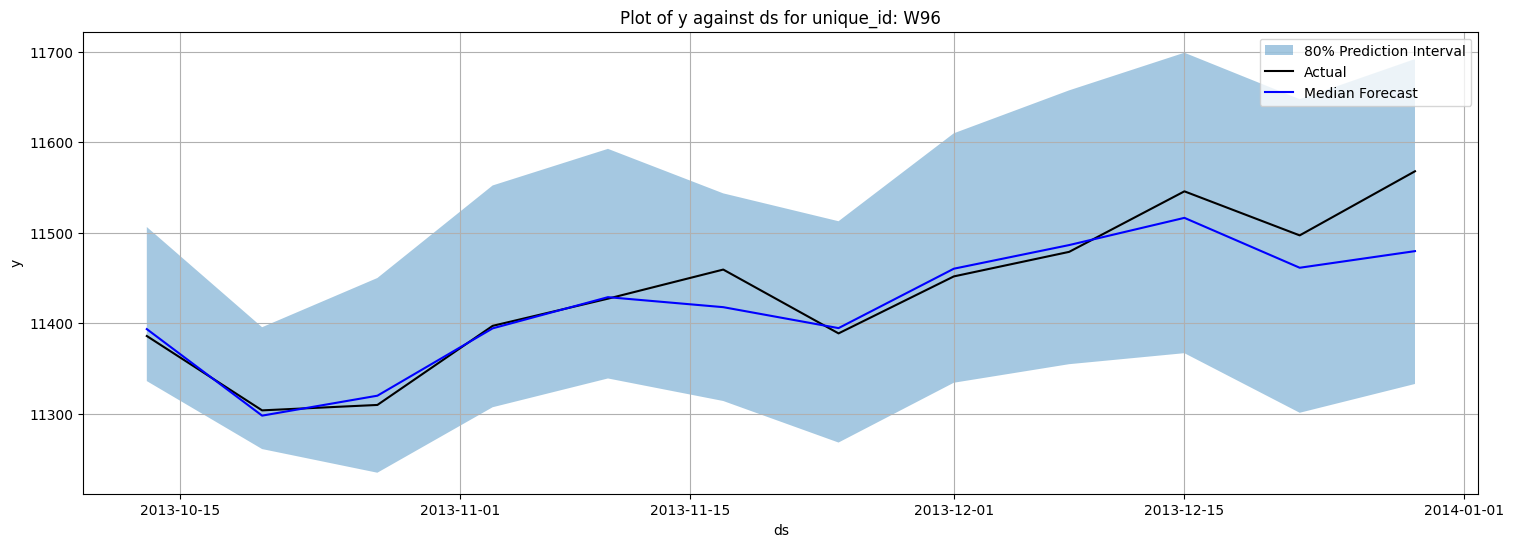

W99


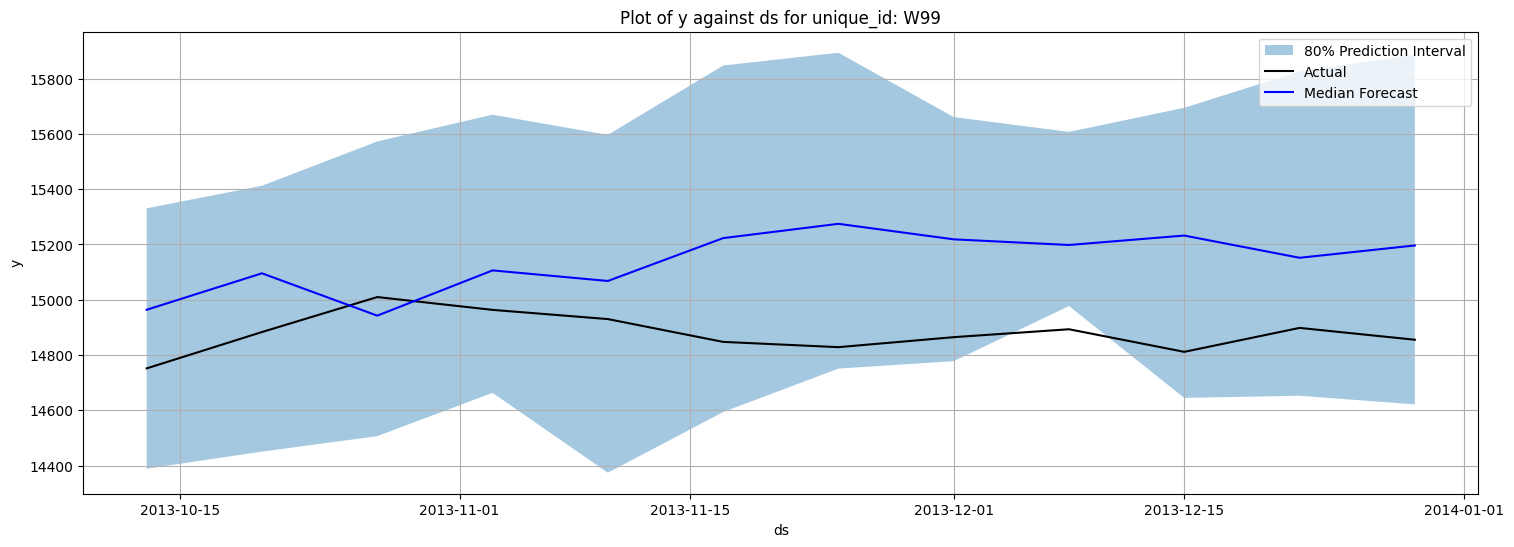

In [34]:
for sku_num in result_df.unique_id.unique():

  print(sku_num)
  plt.figure(figsize=(18, 6))
  plt.fill_between(
      x=result_df[result_df.unique_id == sku_num]['ds'],
      y1=result_df[result_df.unique_id == sku_num]['P10'],
      y2=result_df[result_df.unique_id == sku_num]['P90'],
      alpha=0.4,
      label='80% Prediction Interval'
  )
  plt.plot(result_df[result_df.unique_id == sku_num]['ds'], result_df[result_df.unique_id == sku_num]['y'], c='black', label='Actual')
  plt.plot(result_df[result_df.unique_id == sku_num]['ds'], result_df[result_df.unique_id == sku_num]['PatchTST'], c='blue', label='Median Forecast')
  plt.title(f'Plot of y against ds for unique_id: {sku_num}')
  plt.xlabel('ds')
  plt.ylabel('y')
  plt.legend()
  plt.grid()
  plt.show()

In [35]:
# Calculate SMAPE for each unique_id
for unique_id in result_df.unique_id.unique():
  actual_values = result_df[result_df.unique_id == unique_id]['y']
  predicted_values = result_df[result_df.unique_id == unique_id]['PatchTST']
  smape_value = smape(actual_values, predicted_values)
  print(f"SMAPE for unique_id {unique_id}: {smape_value:.2f}%")


SMAPE for unique_id W100: 1.31%
SMAPE for unique_id W96: 0.18%
SMAPE for unique_id W99: 1.81%


In [36]:
# Calculate the percentage of time whether the true demand fall between the interval for each unique_id
coverage_df = calculate_coverage(result_df)
print(coverage_df.head())

  unique_id    coverage
0      W100   41.666667
1       W96  100.000000
2       W99   91.666667


# Zero-shot Forecasting with Chronos

In [69]:
import torch
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [76]:
# Get Training Data and Transform
train_df = df[df.ds<cut_off_date]
train_df_chronos = TimeSeriesDataFrame(train_df.rename(columns={'ds': 'timestamp', 'unique_id': 'item_id', 'y': 'target'}))

# Zero-shot forecast with Chronos
predictor = TimeSeriesPredictor(prediction_length=output_steps, freq='W', quantile_levels = [0.1, 0.9]).fit(
            train_df_chronos, presets="chronos_base",
            random_seed = 20240710
        )
Y_hat_df_chronos = predictor.predict(train_df_chronos).reset_index().rename(columns={'mean': 'Chronos',
                                                                                     '0.1': 'P10',
                                                                                     '0.9': 'P90',
                                                                                     'timestamp': 'ds',
                                                                                     'item_id': 'unique_id'})
Y_hat_df_chronos.head()

Frequency 'W' stored as 'W-SUN'
Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20240712_171150'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          12
GPU Count:          1
Memory Avail:       47.99 GB / 52.96 GB (90.6%)
Disk Space Avail:   167.07 GB / 201.23 GB (83.0%)
Setting presets to: chronos_base

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'W-SUN',
 'hyperparameters': {'Chronos': {'model_path': 'base'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 12,
 'quantile_levels': [0.1, 0.9],
 'random_seed': 20240710,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Provided train_data has 6852 rows, 3 time series. Median

,unique_id,ds,Chronos,P10,P90
0,W100,2013-10-13,11511.771484,11375.755859,11623.054688
1,W100,2013-10-20,11458.188477,11293.323242,11631.297949
2,W100,2013-10-27,11425.214844,11285.079883,11540.622070
3,W100,2013-11-03,11396.364258,11210.889648,11540.622070
4,W100,2013-11-10,11536.500000,11293.323242,11721.974023


In [77]:
result_df = pd.merge(df, Y_hat_df_chronos, on=['unique_id', 'ds'], how='inner')
result_df.head()

,unique_id,ds,y,Chronos,P10,P90
0,W100,2013-10-13,11875.50,11511.771484,11375.755859,11623.054688
1,W100,2013-10-20,11517.02,11458.188477,11293.323242,11631.297949
2,W100,2013-10-27,11305.80,11425.214844,11285.079883,11540.622070
3,W100,2013-11-03,11423.14,11396.364258,11210.889648,11540.622070
4,W100,2013-11-10,11647.50,11536.500000,11293.323242,11721.974023


W100


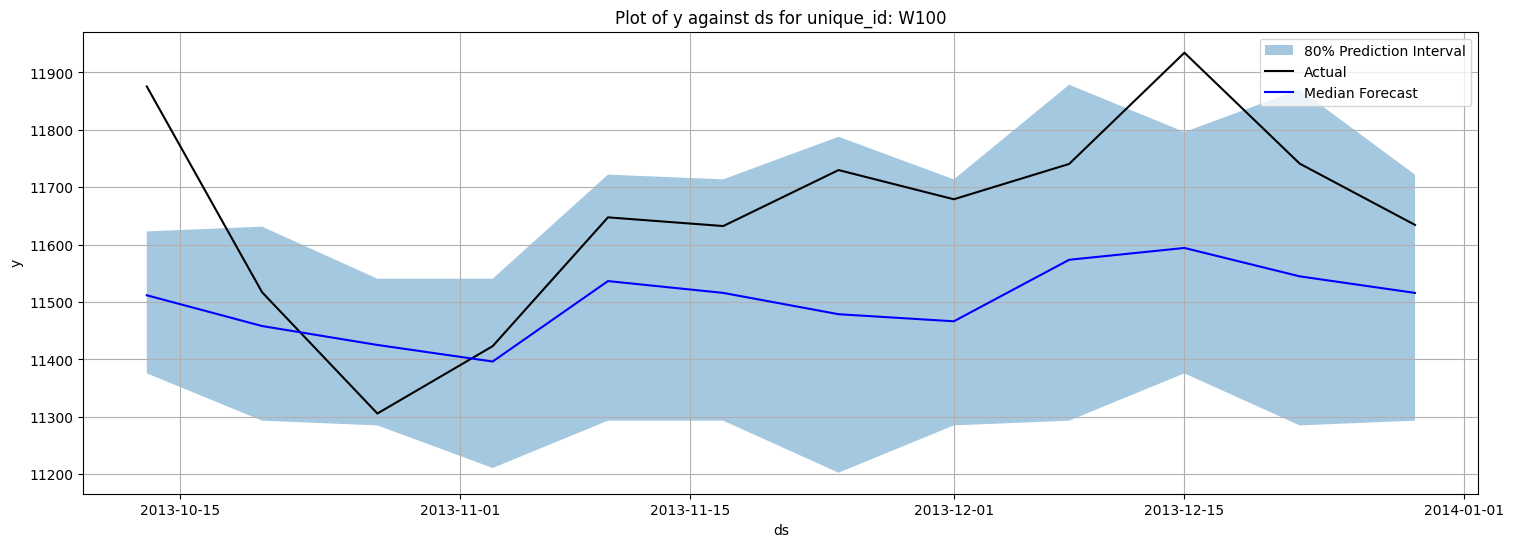

W96


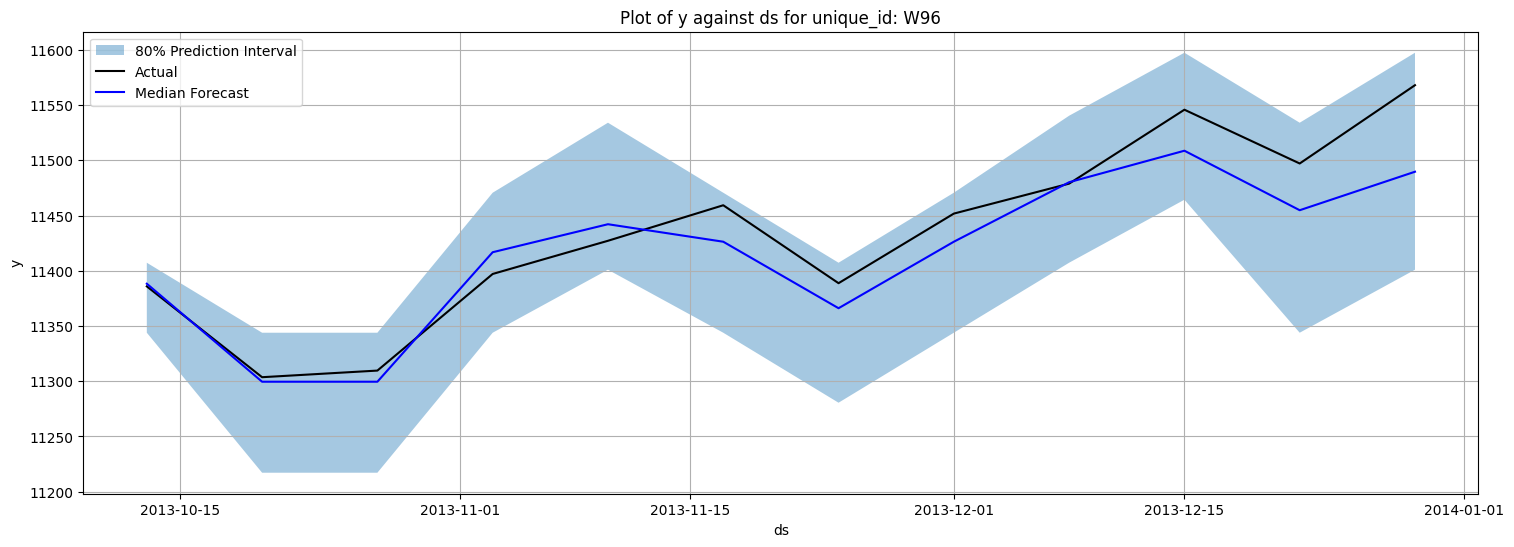

W99


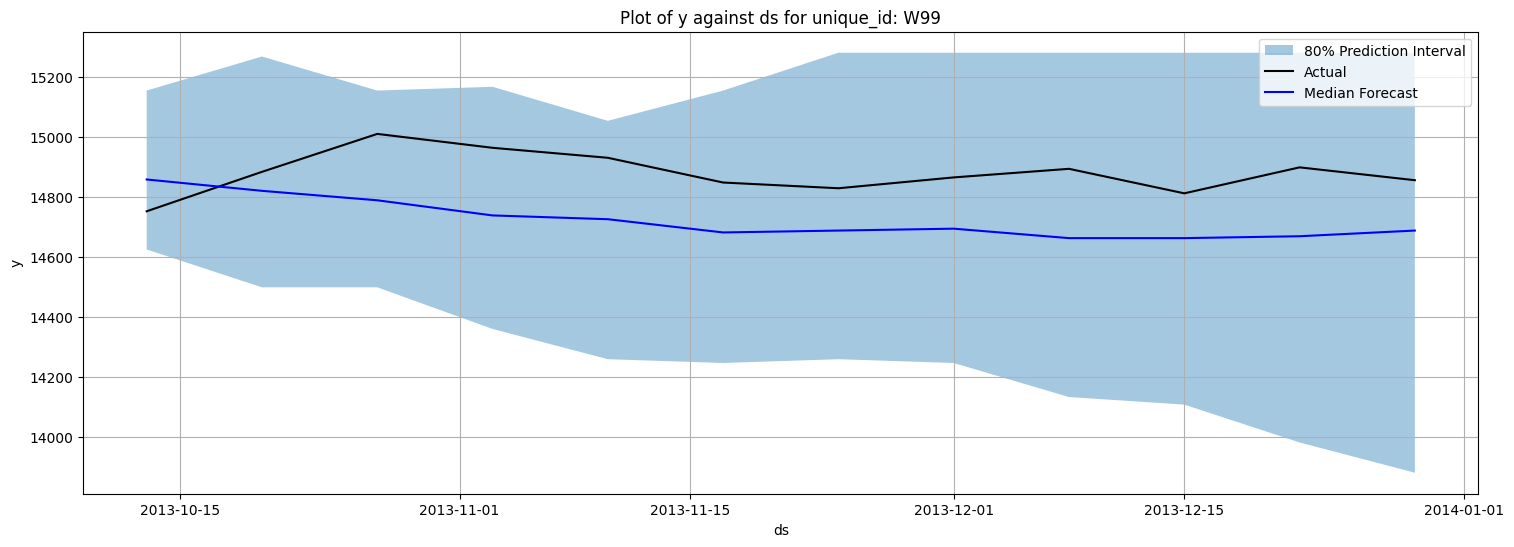

In [78]:
for sku_num in result_df.unique_id.unique():

  print(sku_num)
  plt.figure(figsize=(18, 6))
  plt.fill_between(
      x=result_df[result_df.unique_id == sku_num]['ds'],
      y1=result_df[result_df.unique_id == sku_num]['P10'],
      y2=result_df[result_df.unique_id == sku_num]['P90'],
      alpha=0.4,
      label='80% Prediction Interval'
  )
  plt.plot(result_df[result_df.unique_id == sku_num]['ds'], result_df[result_df.unique_id == sku_num]['y'], c='black', label='Actual')
  plt.plot(result_df[result_df.unique_id == sku_num]['ds'], result_df[result_df.unique_id == sku_num]['Chronos'], c='blue', label='Median Forecast')
  plt.title(f'Plot of y against ds for unique_id: {sku_num}')
  plt.xlabel('ds')
  plt.ylabel('y')
  plt.legend()
  plt.grid()
  plt.show()

In [79]:
# Calculate SMAPE for each unique_id
for unique_id in result_df.unique_id.unique():
  actual_values = result_df[result_df.unique_id == unique_id]['y']
  predicted_values = result_df[result_df.unique_id == unique_id]['Chronos']
  smape_value = smape(actual_values, predicted_values)
  print(f"SMAPE for unique_id {unique_id}: {smape_value:.2f}%")


SMAPE for unique_id W100: 1.49%
SMAPE for unique_id W96: 0.21%
SMAPE for unique_id W99: 1.17%


In [80]:
# Calculate the percentage of time whether the true demand fall between the interval for each unique_id
coverage_df = calculate_coverage(result_df)
print(coverage_df.head())

  unique_id    coverage
0      W100   83.333333
1       W96  100.000000
2       W99  100.000000
